# Image Convolution and Deconvolution based on FFT

This notebook display the convolution and deconvolution process through the FFT.
The deconvolution process uses the Richarson-Lucy algorithm for image deconvolution

In [2]:
import pyclesperanto as cle
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

cle.select_device(1,"gpu")

(OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.230.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24217 MB
	Maximum Object Size:         6054 MB
	Max Clock Frequency:         2625 MHz
	Image Support:               Yes

## Load an image, psf, and ground truth

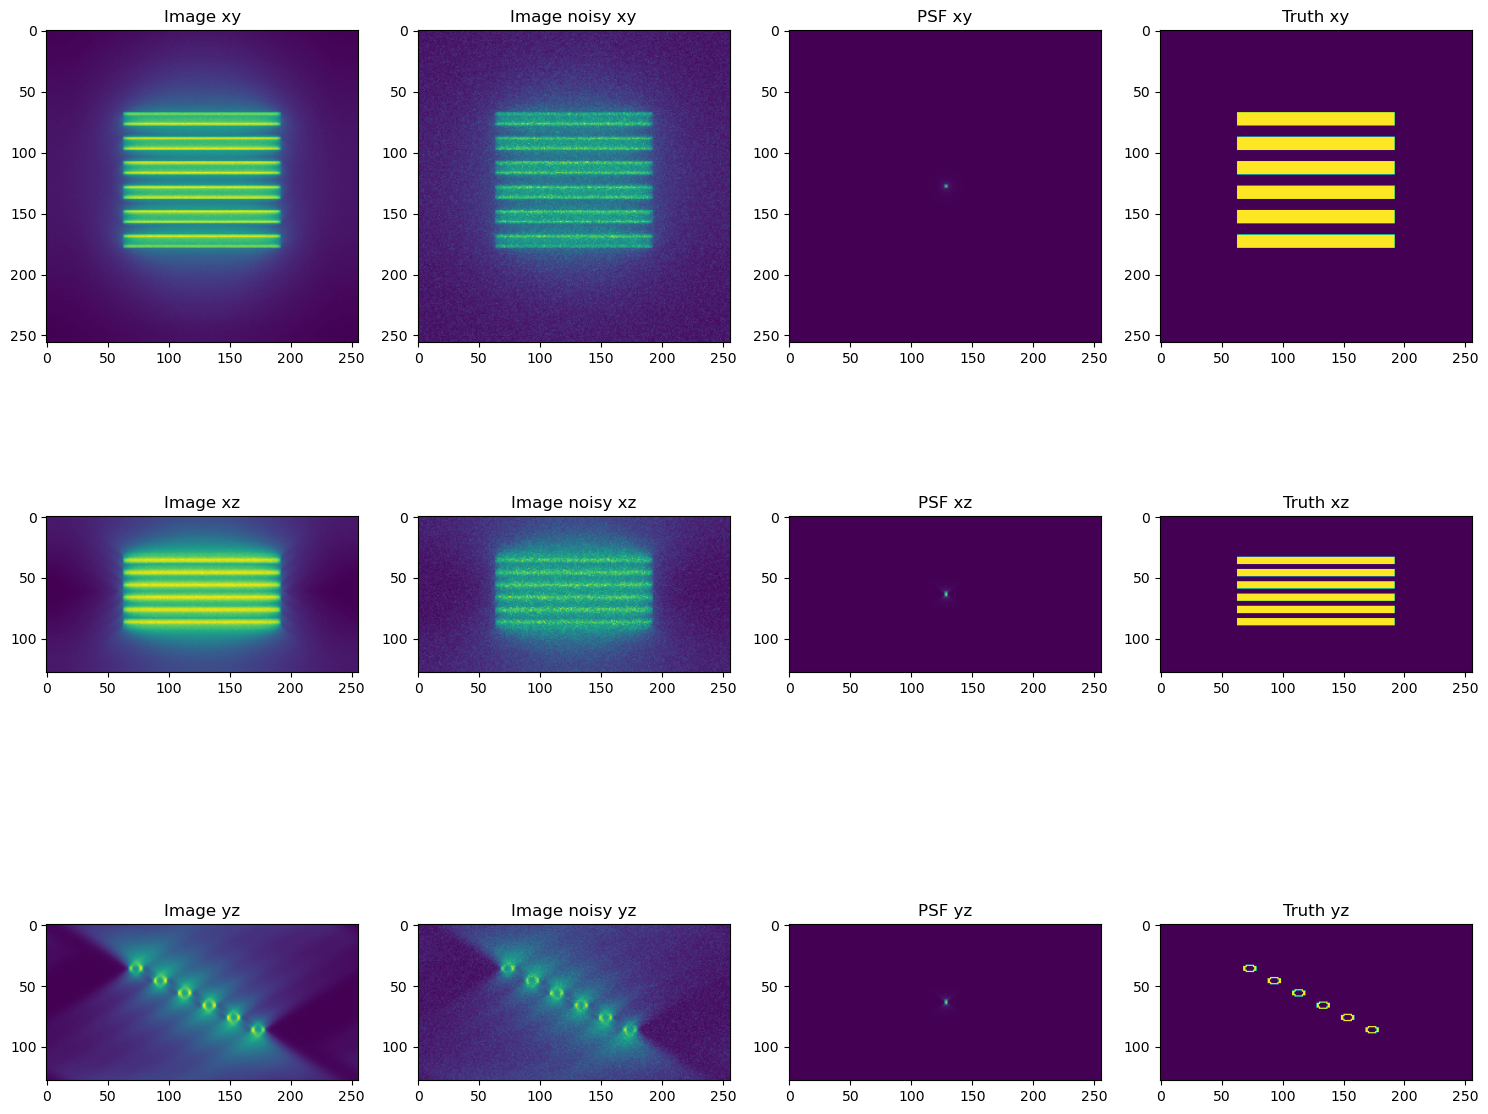

In [3]:
data_folder = '/home/strigaud/Downloads/deconvolution'
im_name = 'Bars-G10-P30-stack.tif'
im_name_noise = 'Bars-G10-P15-stack.tif'
psf_name = 'PSF-Bars-stack.tif'
truth_name = 'Bars-stack.tif'

im = imread(data_folder + '/' + im_name).astype(np.float32)
im_noise = imread(data_folder + '/' + im_name_noise).astype(np.float32)
psf = imread(data_folder + '/' + psf_name).astype(np.float32)
# shift the psf center to the image top left corner (central pixel at 0,0,0)
# psf = np.roll(psf, -np.array(psf.shape) // 2, tuple(range(psf.ndim)))

truth = imread(data_folder + '/' + truth_name).astype(np.float32)

# plot the image, psf and ground truth in a subplot
fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[4].imshow(im.max(axis=1))
ax[4].set_title('Image xz')
ax[8].imshow(im.max(axis=2))
ax[8].set_title('Image yz')

ax[1].imshow(im_noise.max(axis=0))
ax[1].set_title('Image noisy xy')
ax[5].imshow(im_noise.max(axis=1))
ax[5].set_title('Image noisy xz')
ax[9].imshow(im_noise.max(axis=2))
ax[9].set_title('Image noisy yz')

ax[2].imshow(psf.max(axis=0))
ax[2].set_title('PSF xy')
ax[6].imshow(psf.max(axis=1))
ax[6].set_title('PSF xz')
ax[10].imshow(psf.max(axis=2))
ax[10].set_title('PSF yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()

## Convolution operation

We can see how the convolution process works by convoluting a `truth` sample with a `psf` kernel.

Convolution using FFT have a set of requirements, mainly the `psf` kernel must be padded to the same size of the image to process, and the `psf` center point must be set at `(0,0,0)`.

First test to apply a convolution between two arrays. Both `input` and `kernel` must have same dimensions, and the kernel must be cyclically shift so that the central element of the kernel is at `(0,0,)`.

In [4]:
# Create an example input image
input_np = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]], dtype=np.float32)

# Create a kernel (e.g., 3x3 averaging filter)
kernel_np = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32)

# Convert to GPU arrays
input_gpu = cle.push(input_np)
kernel_gpu = cle.push(kernel_np)

# Create an output array with the same shape as input
output_gpu = cle.create_like(input_gpu)

# Call _convolution (not typically recommended)
output_gpu = cle.__experimental__.vk_convolution(input_gpu, kernel_gpu, output_gpu, correlate=False)

# Retrieve result
output_np = cle.pull(output_gpu)
print(output_np)

[[36. 36. 36.]
 [36. 36. 36.]
 [36. 36. 36.]]


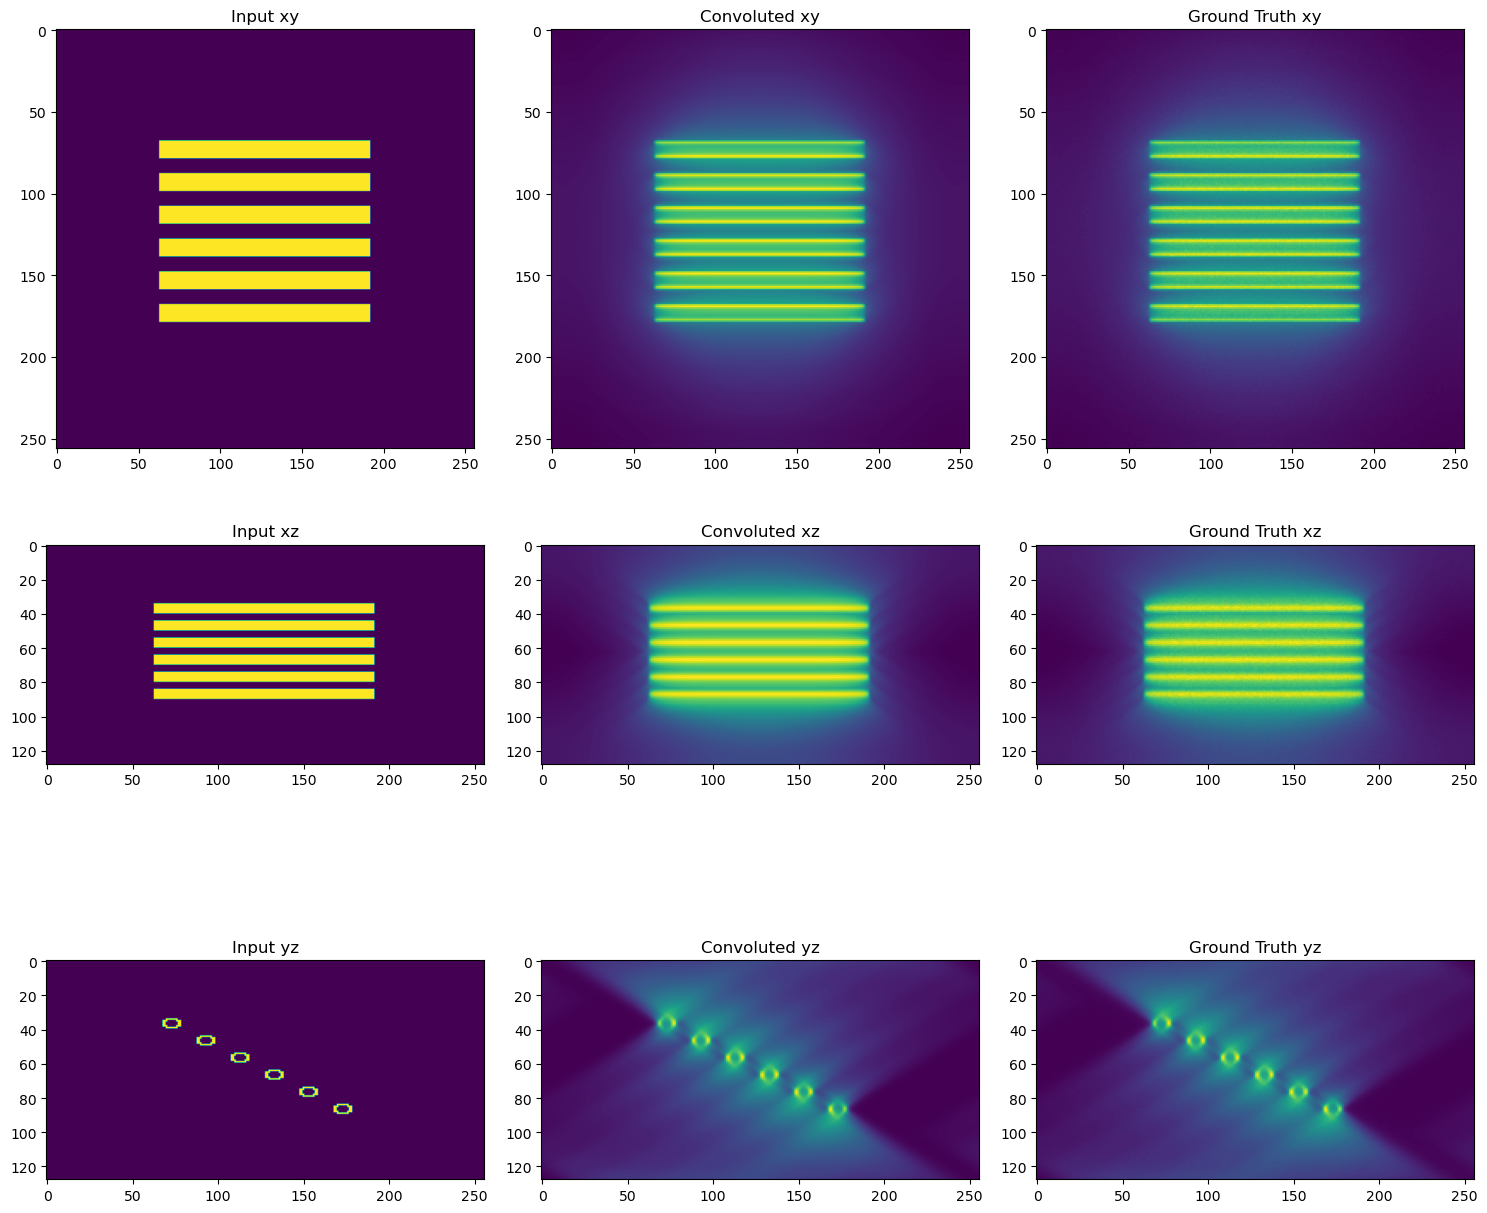

In [5]:
# the psf is alredy padded to the image size but we need to shift its center to the top left corner
psf_shifted = np.roll(psf, -np.array(psf.shape) // 2, tuple(range(psf.ndim)))

# Convert to GPU arrays
input_gpu = cle.push(truth)
kernel_gpu = cle.push(psf_shifted)

# Call the convolution operation
output_gpu = cle.__experimental__.vk_convolution(input_gpu, kernel_gpu, None, correlate=False)
output_np = cle.pull(output_gpu)

# plot the image, psf and ground truth in a subplot
fig, axs = plt.subplots(3,3, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(truth.max(axis=0))
ax[0].set_title('Input xy')
ax[3].imshow(truth.max(axis=1))
ax[3].set_title('Input xz')
ax[6].imshow(truth.max(axis=2))
ax[6].set_title('Input yz')

ax[1].imshow(output_np.max(axis=0))
ax[1].set_title('Convoluted xy')
ax[4].imshow(output_np.max(axis=1))
ax[4].set_title('Convoluted xz')
ax[7].imshow(output_np.max(axis=2))
ax[7].set_title('Convoluted yz')

ax[2].imshow(im.max(axis=0))
ax[2].set_title('Ground Truth xy')
ax[5].imshow(im.max(axis=1))
ax[5].set_title('Ground Truth xz')
ax[8].imshow(im.max(axis=2))
ax[8].set_title('Ground Truth yz')

plt.tight_layout()
plt.show()

## Deconvolution

This is the inverse process of the deconvolution, here we show a two example, with and without regularization factor. The regularization factor improve the smoothness of the estimated output, principally usefull for noisy data.

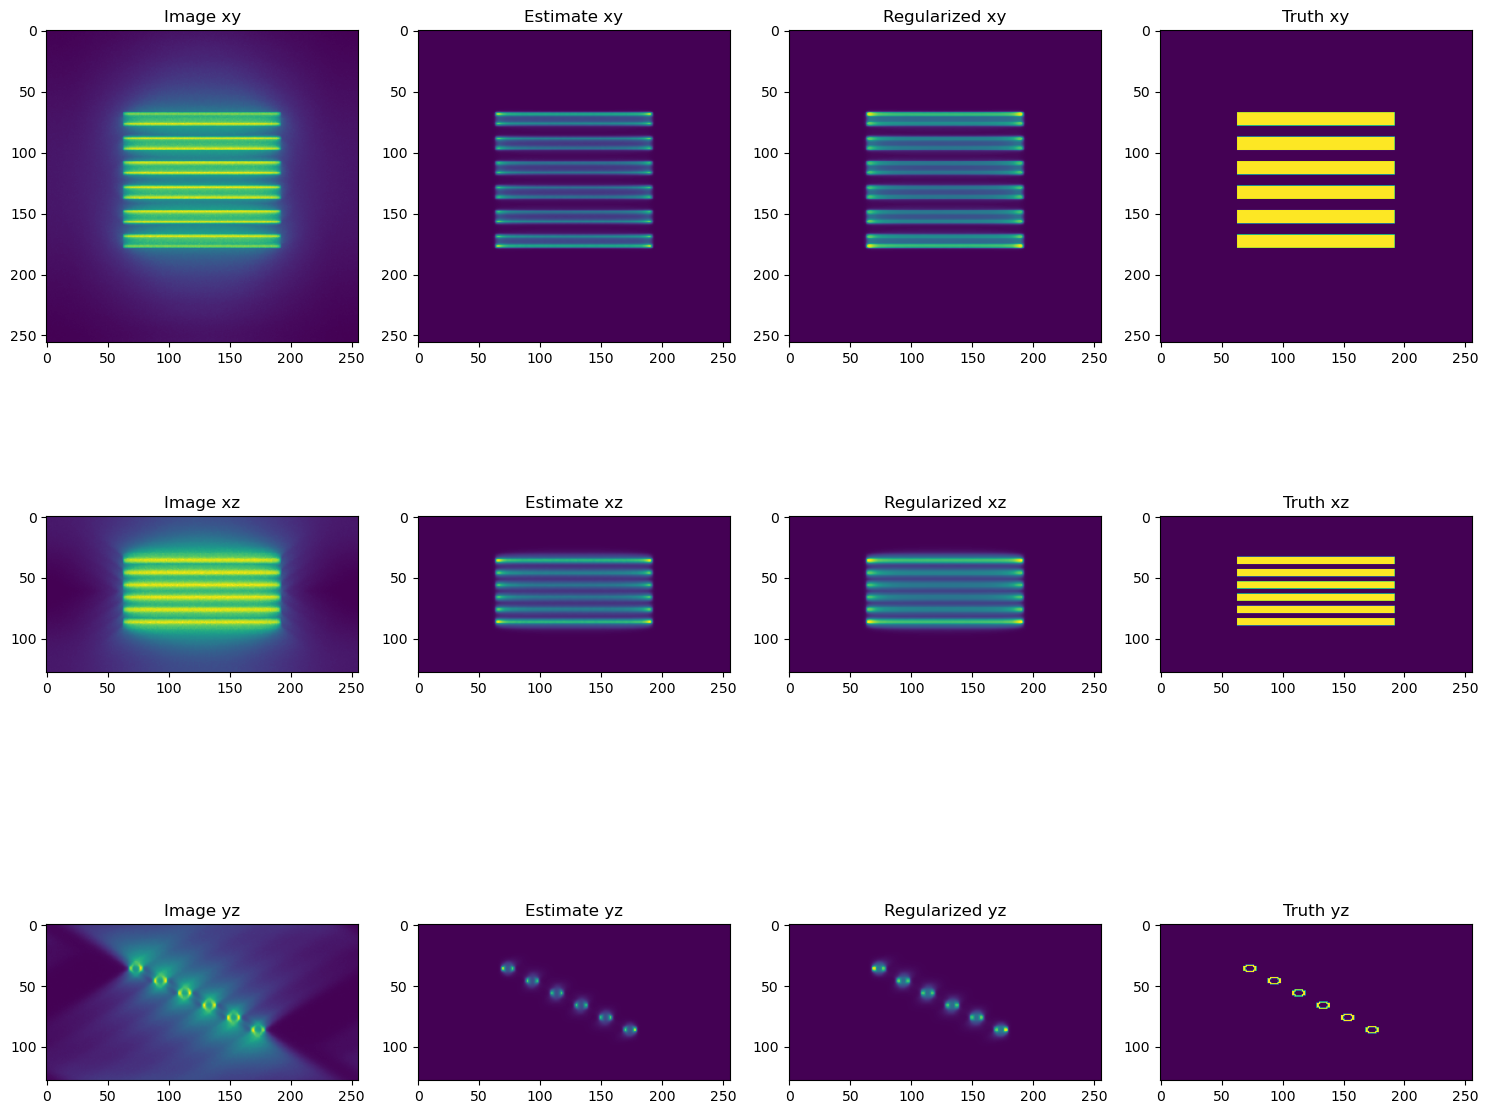

In [6]:
# deconvolution
input_gpu = cle.push(im)
kernel_gpu = cle.push(psf_shifted)
output_gpu = cle.create_like(input_gpu)
output_gpu_reg = cle.create_like(input_gpu)
output_gpu.fill(1)
output_gpu_reg.fill(1)

cle.__experimental__.vk_deconvolution(input_gpu, kernel_gpu, None, output_gpu, 100, 0)
cle.__experimental__.vk_deconvolution(input_gpu, kernel_gpu, None, output_gpu_reg, 100, 0.002)
out = cle.pull(output_gpu)
out_reg = cle.pull(output_gpu_reg)


fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im.max(axis=0))
ax[0].set_title('Image xy')
ax[4].imshow(im.max(axis=1))
ax[4].set_title('Image xz')
ax[8].imshow(im.max(axis=2))
ax[8].set_title('Image yz')

ax[1].imshow(out.max(axis=0))
ax[1].set_title('Estimate xy')
ax[5].imshow(out.max(axis=1))
ax[5].set_title('Estimate xz')
ax[9].imshow(out.max(axis=2))
ax[9].set_title('Estimate yz')

ax[2].imshow(out_reg.max(axis=0))
ax[2].set_title('Regularized xy')
ax[6].imshow(out_reg.max(axis=1))
ax[6].set_title('Regularized xz')
ax[10].imshow(out_reg.max(axis=2))
ax[10].set_title('Regularized yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()

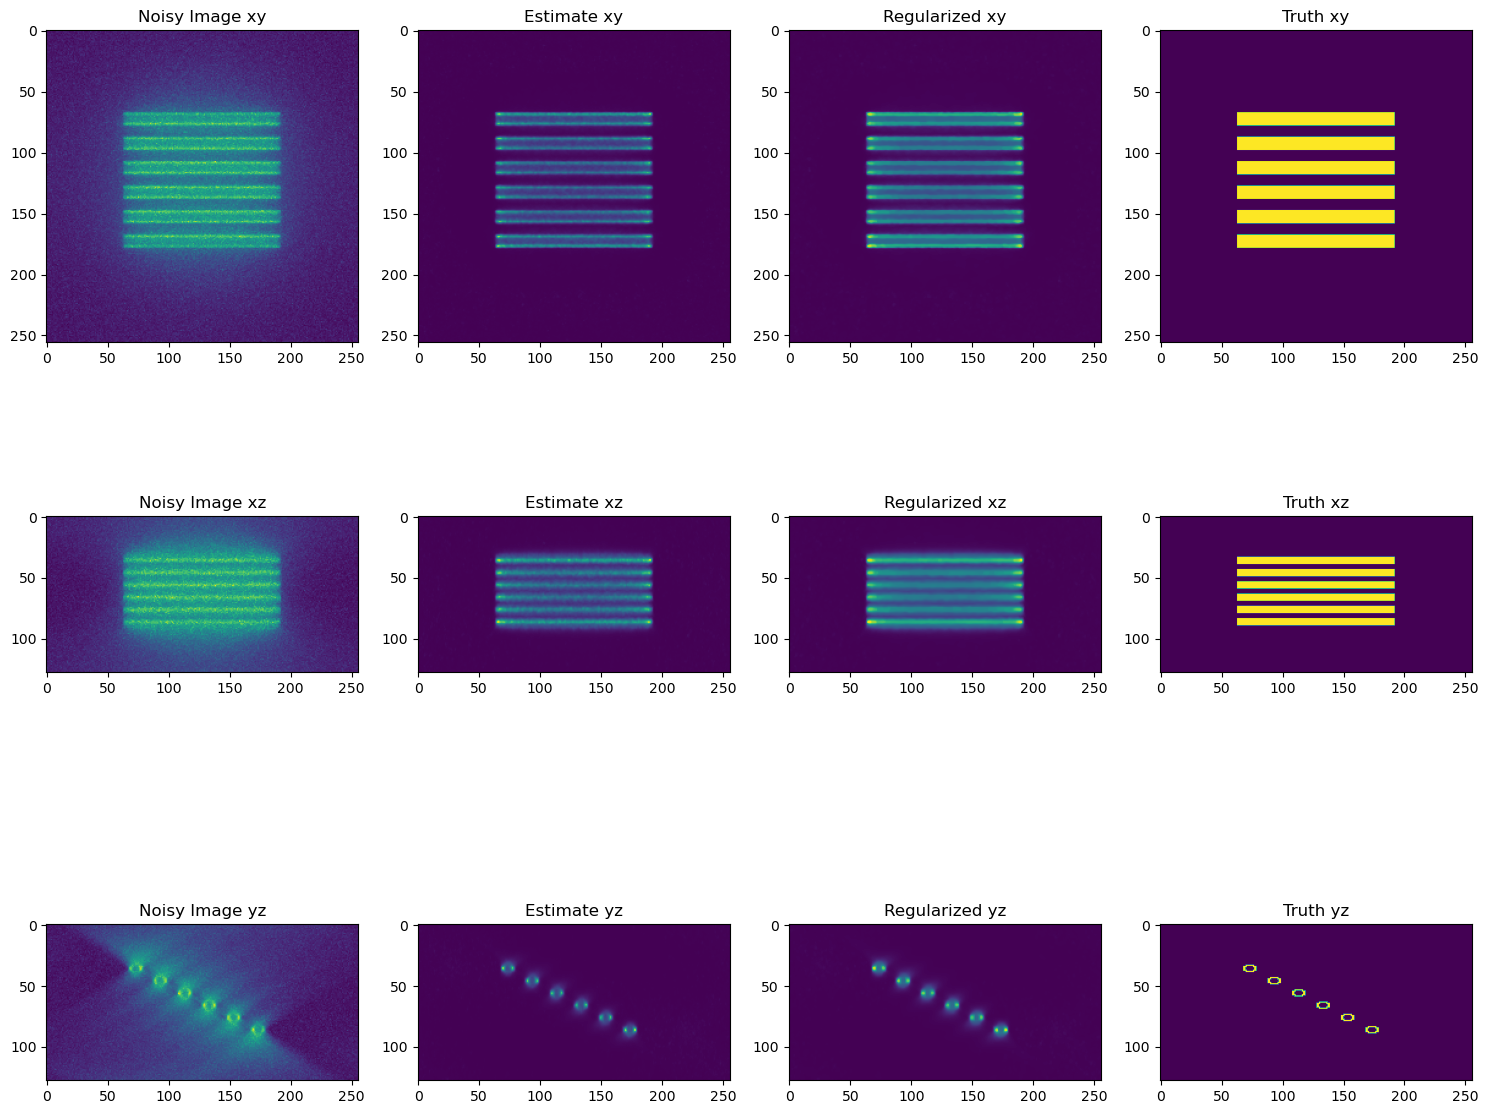

In [7]:
# deconvolution
input_gpu = cle.push(im_noise)
kernel_gpu = cle.push(psf_shifted)
output_gpu = cle.create_like(input_gpu)
output_gpu_reg = cle.create_like(input_gpu)
output_gpu.fill(1)
output_gpu_reg.fill(1)

cle.__experimental__.vk_deconvolution(input_gpu, kernel_gpu, None, output_gpu, 100, 0)
cle.__experimental__.vk_deconvolution(input_gpu, kernel_gpu, None, output_gpu_reg, 100, 0.002)
out = cle.pull(output_gpu)
out_reg = cle.pull(output_gpu_reg)


fig, axs = plt.subplots(3,4, figsize=(15,13))
ax = axs.ravel()

ax[0].imshow(im_noise.max(axis=0))
ax[0].set_title('Noisy Image xy')
ax[4].imshow(im_noise.max(axis=1))
ax[4].set_title('Noisy Image xz')
ax[8].imshow(im_noise.max(axis=2))
ax[8].set_title('Noisy Image yz')

ax[1].imshow(out.max(axis=0))
ax[1].set_title('Estimate xy')
ax[5].imshow(out.max(axis=1))
ax[5].set_title('Estimate xz')
ax[9].imshow(out.max(axis=2))
ax[9].set_title('Estimate yz')

ax[2].imshow(out_reg.max(axis=0))
ax[2].set_title('Regularized xy')
ax[6].imshow(out_reg.max(axis=1))
ax[6].set_title('Regularized xz')
ax[10].imshow(out_reg.max(axis=2))
ax[10].set_title('Regularized yz')

ax[3].imshow(truth.max(axis=0))
ax[3].set_title('Truth xy')
ax[7].imshow(truth.max(axis=1))
ax[7].set_title('Truth xz')
ax[11].imshow(truth.max(axis=2))
ax[11].set_title('Truth yz')

plt.tight_layout()
plt.show()